In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('data.csv')

In [15]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

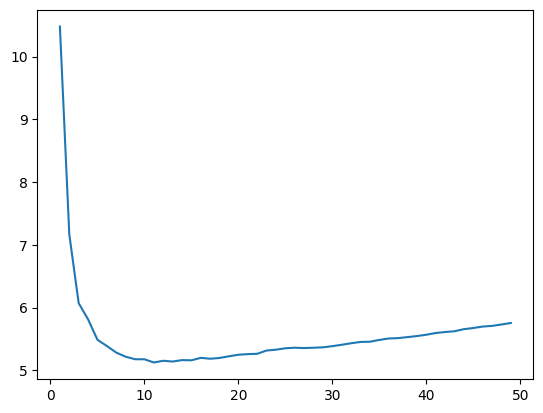

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

losses = []
k_values = list(range(1, 50))

for k in range(1, 50):
    knn = KNeighborsRegressor(n_neighbors=k , metric= 'euclidean' , n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    losses.append(mean_squared_error(y_test, y_pred))

plt.plot(k_values, losses)

In [18]:
k = k_values[np.argmin(losses)]
print(f'Best k: {k}')

Best k: 11


In [19]:
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)

y_pred = knn.predict(X_test)

y_data = knn.predict(X)

print('Train Set:')
print(f'MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'R2: {r2_score(y_train, y_train_pred)}')

print()

print('Test Set:')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

print()

print('Data Set:')
print(f'MSE: {mean_squared_error(y, y_data)}')
print(f'MAE: {mean_absolute_error(y, y_data)}')
print(f'R2: {r2_score(y, y_data)}')

Train Set:
MSE: 4.657543636656428
MAE: 1.5013403809902715
R2: 0.9025542220799434

Test Set:
MSE: 5.126708560151132
MAE: 1.5932485934569702
R2: 0.895335933125192

Data Set:
MSE: 4.814183347532257
MAE: 1.5320101543358005
R2: 0.9001082276336243
